# Supply Chain ML Notebook

This notebook demonstrates end-to-end steps for dataset understanding, preprocessing, modeling, and visualization for several ML tasks in a blockchain-enabled herbal supply chain.

It covers:
- Spatio-temporal anomaly detection (harvest validation)
- RFID tamper/fraud detection (simulated)
- Quality/lab-result anomaly detection (simulated)
- Supply-chain graph anomaly detection (graph feature + anomaly detector)



In [2]:
# Imports and helper functions
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import networkx as nx

plt.rcParams['figure.figsize'] = (8,5)

try:
    from caas_jupyter_tools import display_dataframe_to_user
    def show_df_preview(df, name='DataFrame'):
        display_dataframe_to_user(name, df.head(10))
except ImportError:
    def show_df_preview(df, name='DataFrame'):
        print(f"--- {name} preview ---")
        display(df.head(10))

def ensure_dir(path):
    os.makedirs(os.path.dirname(path), exist_ok=True)


In [3]:
# Load dataset if available, otherwise synthesize a realistic dataset
csv_path = './trust_chain_dataset.csv'
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print('Loaded dataset from', csv_path)
else:
    print('No dataset found at', csv_path, '- synthesizing demo data (10k rows).')
    np.random.seed(42)
    n = 10000
    sample = {
        'Transaction ID': [f'TX{100000+i:05d}' for i in range(n)],
        'Timestamp': pd.date_range('2024-07-01', periods=n, freq='H').astype(str),
        'Item ID': np.random.randint(9000, 9950, n),
        'Supplier ID': np.random.choice([f'S{i}' for i in range(1,51)], n),
        'Customer ID': np.random.choice([f'C{i}' for i in range(1,201)], n),
        'Location': np.random.choice(['Uttarakhand','Maharashtra','Delhi','Chicago','NY'], n, p=[0.25,0.2,0.2,0.2,0.15]),
        'Temperature': np.random.normal(25, 5, n),
        'Humidity': np.clip(np.random.normal(55, 15, n), 5, 100),
        'GPS Coordinates': np.nan, # will fill per location
        'Order Amount': np.random.randint(500, 5000, n),
        'Quantity Shipped': np.random.randint(1, 500, n),
        'Order Status': np.random.choice(['Pending','Shipped','Delivered','Cancelled'], n, p=[0.2,0.3,0.45,0.05]),
        'Payment Status': np.random.choice(['Paid','Overdue','Pending'], n, p=[0.7,0.2,0.1]),
        'Time to Delivery': np.random.randint(1, 15, n)
    }
    df = pd.DataFrame(sample)
    # assign GPS coordinates by Location (rough examples)
    def random_coord(loc):
        if loc == 'Uttarakhand':
            return (30 + np.random.rand(), 79 + np.random.rand())  # rough lat lon
        if loc == 'Maharashtra':
            return (19 + np.random.rand(), 73 + np.random.rand())
        if loc == 'Delhi':
            return (28 + np.random.rand(), 77 + np.random.rand())
        if loc == 'Chicago':
            return (41 + np.random.rand(), -87 + np.random.rand())
        if loc == 'NY':
            return (40 + np.random.rand(), -74 + np.random.rand())
        return (0,0)
    df['GPS Coordinates'] = df['Location'].apply(lambda x: random_coord(x))
    # Quantity mismatch and Fraud Indicator (simulate rare frauds)
    df['Quantity Mismatch'] = np.random.poisson(1, n)
    df['Fraud Indicator'] = (np.random.rand(n) < 0.02).astype(int)  # 2% labeled fraud for evaluation
    # Add placeholder Transaction Hash, Smart Contract Status, Compliance Check
    df['Transaction Hash'] = ['0x' + ''.join(np.random.choice(list('0123456789abcdef'), 4)) for _ in range(n)]
    df['Smart Contract Status'] = np.random.choice(['Active','Completed','Triggered'], n, p=[0.7,0.25,0.05])
    df['Compliance Check'] = (np.random.rand(n) < 0.9).astype(int)
    # Save to disk for reuse
    df.to_csv('/mnt/data/synth_supplychain.csv', index=False)
    print('Synthesized dataset saved to /mnt/data/synth_supplychain.csv')

# Quick preview
show_df_preview(df, 'supply_chain_sample')
df.shape


Loaded dataset from ./trust_chain_dataset.csv
--- supply_chain_sample preview ---


,Transaction ID,Timestamp,Item ID,Supplier ID,Customer ID,Location,Temperature,Humidity,GPS Coordinates,Order Amount,Quantity Shipped,Order Status,Payment Status,Time to Delivery,Quantity Mismatch,Fraud Indicator,Transaction Hash,Smart Contract Status,Compliance Check
0,TX00001,2025-02-05 13:58:29.739685,9102,S4,C9,Chicago,12.248374,67.459523,"(36.4275, -116.2052)",2996,153,Pending,Overdue,6,12,0,0xc11a,Active,0
1,TX00002,2025-02-04 13:58:29.739685,9435,S8,C6,Chicago,18.968854,41.879883,"(38.3798, -106.2317)",1182,76,Delivered,Paid,4,9,1,0x7b36,Completed,0
2,TX00003,2025-02-03 13:58:29.739685,9860,S6,C2,Chicago,15.050121,41.514624,"(41.5735, -93.3818)",1939,63,Pending,Overdue,5,2,1,0x15ce,Triggered,0
3,TX00004,2025-02-02 13:58:29.739685,9270,S3,C2,NY,17.310409,41.266084,"(36.2805, -96.2122)",2439,74,Shipped,Paid,6,1,1,0x8be6,Triggered,1
4,TX00005,2025-02-01 13:58:29.739685,9106,S4,C3,Chicago,6.741711,67.905965,"(38.316, -87.2957)",2915,101,Shipped,Paid,1,10,0,0x8a2d,Active,1
5,TX00006,2025-01-31 13:58:29.739685,9071,S2,C1,LA,7.908521,61.445419,"(41.2176, -76.6833)",2237,189,Shipped,Overdue,2,14,0,0x6046,Active,1
6,TX00007,2025-01-30 13:58:29.739685,9700,S1,C9,Chicago,10.161627,54.809696,"(39.7431, -95.4339)",2052,72,Shipped,Paid,2,12,0,0xc3a7,Active,0
7,TX00008,2025-01-29 13:58:29.739685,9020,S8,C10,SF,7.823610,67.024316,"(35.7995, -101.8637)",2026,196,Shipped,Overdue,7,13,0,0xc392,Completed,1
8,TX00009,2025-01-28 13:58:29.739685,9614,S1,C4,SF,18.596976,62.144171,"(37.9103, -114.2233)",1324,169,Shipped,Paid,3,14,0,0x0426,Triggered,1
9,TX00010,2025-01-27 13:58:29.739685,9121,S1,C5,Chicago,8.253358,40.293394,"(36.0512, -75.6996)",2009,50,Shipped,Paid,4,9,0,0xf4c2,Triggered,1


(10348, 19)

## Exploring Data
We inspect columns, types, missing values, and distributions.

In [4]:
# EDA: types, missing, basic stats
print('Columns:', df.columns.tolist())
print('\nDTypes:\n', df.dtypes)
print('\nMissing values:\n', df.isna().sum())
display(df.describe(include='all').T.head(30))


Columns: ['Transaction ID', 'Timestamp', 'Item ID', 'Supplier ID', 'Customer ID', 'Location', 'Temperature', 'Humidity', 'GPS Coordinates', 'Order Amount', 'Quantity Shipped', 'Order Status', 'Payment Status', 'Time to Delivery', 'Quantity Mismatch', 'Fraud Indicator', 'Transaction Hash', 'Smart Contract Status', 'Compliance Check']

DTypes:
 Transaction ID            object
Timestamp                 object
Item ID                    int64
Supplier ID               object
Customer ID               object
Location                  object
Temperature              float64
Humidity                 float64
GPS Coordinates           object
Order Amount               int64
Quantity Shipped           int64
Order Status              object
Payment Status            object
Time to Delivery           int64
Quantity Mismatch          int64
Fraud Indicator            int64
Transaction Hash          object
Smart Contract Status     object
Compliance Check           int64
dtype: object

Missing value

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Transaction ID,10348,10348,TX00001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Timestamp,10348,10348,2025-02-05 13:58:29.739685,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item ID,10348.0,NaN,NaN,NaN,9503.309142,289.866321,9000.0,9250.0,9505.0,9757.0,9999.0
Supplier ID,10348,10,S10,1082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer ID,10348,10,C4,1078,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,10348,4,SF,2671,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature,10348.0,NaN,NaN,NaN,12.482743,4.324497,5.001536,8.781563,12.515032,16.222792,19.999608
Humidity,10348.0,NaN,NaN,NaN,60.093394,11.552714,40.003731,50.163538,60.021123,70.142585,79.991885
GPS Coordinates,10348,10348,"(36.4275, -116.2052)",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Order Amount,10348.0,NaN,NaN,NaN,2005.256088,574.674764,1000.0,1515.0,2009.0,2505.0,2999.0


## Preprocessing
- Parse timestamps
- Expand GPS coords into lat/lon
- Encode categorical IDs
- Scale numeric features


In [7]:
import re

def parse_gps(coord):
    if pd.isna(coord):
        return (np.nan, np.nan)
    if isinstance(coord, (list, tuple)) and len(coord) == 2:
        return (float(coord[0]), float(coord[1]))
    if isinstance(coord, str):
        # Remove parentheses/brackets and split by comma
        nums = re.findall(r"[-+]?\d*\.\d+|\d+", coord)
        if len(nums) == 2:
            return (float(nums[0]), float(nums[1]))
    return (np.nan, np.nan)

# Apply to column
df[['lat', 'lon']] = df['GPS Coordinates'].apply(parse_gps).apply(pd.Series)


In [11]:
print(data['GPS Coordinates'].head(3))


0    (36.4275, -116.2052)
1    (38.3798, -106.2317)
2     (41.5735, -93.3818)
Name: GPS Coordinates, dtype: object


In [8]:
# Preprocessing
data = df.copy()

# Parse timestamp
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

# Extract time features
data['Month'] = data['Timestamp'].dt.month.fillna(0).astype(int)
data['Hour'] = data['Timestamp'].dt.hour.fillna(0).astype(int)

# GPS split using parser
data[['lat', 'lon']] = data['GPS Coordinates'].apply(parse_gps).apply(pd.Series)

# Label encode Supplier and Customer IDs
le_sup = LabelEncoder()
le_cust = LabelEncoder()
data['Supplier_enc'] = le_sup.fit_transform(data['Supplier ID'].astype(str))
data['Customer_enc'] = le_cust.fit_transform(data['Customer ID'].astype(str))

# Numeric columns for scaling
num_cols = [
    'Temperature','Humidity','Order Amount','Quantity Shipped',
    'Time to Delivery','lat','lon','Month','Hour'
]
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

print('Preprocessing complete. Sample:')
show_df_preview(
    data[['Transaction ID','Timestamp','Supplier ID','Customer ID',
          'lat','lon','Month','Hour','Temperature','Humidity','Fraud Indicator']],
    'preprocessed_preview'
)


Preprocessing complete. Sample:
--- preprocessed_preview preview ---


,Transaction ID,Timestamp,Supplier ID,Customer ID,lat,lon,Month,Hour,Temperature,Humidity,Fraud Indicator
0,TX00001,2025-02-05 13:58:29.739685,S4,C9,-0.695263,-1.446880,-1.309349,0.0,-0.054198,0.637641,0
1,TX00002,2025-02-04 13:58:29.739685,S8,C6,0.149315,-0.680970,-1.309349,0.0,1.499926,-1.576633,1
2,TX00003,2025-02-03 13:58:29.739685,S6,C2,1.530930,0.305832,-1.309349,0.0,0.593711,-1.608251,1
3,TX00004,2025-02-02 13:58:29.739685,S3,C2,-0.758857,0.088473,-1.309349,0.0,1.116407,-1.629766,1
4,TX00005,2025-02-01 13:58:29.739685,S4,C3,0.121714,0.773211,-1.309349,0.0,-1.327625,0.676287,0
5,TX00006,2025-01-31 13:58:29.739685,S2,C1,1.376966,1.588185,-1.597647,0.0,-1.057798,0.117037,0
6,TX00007,2025-01-30 13:58:29.739685,S1,C9,0.739087,0.148242,-1.597647,0.0,-0.536763,-0.457378,0
7,TX00008,2025-01-29 13:58:29.739685,S8,C10,-0.966940,-0.345532,-1.597647,0.0,-1.077434,0.599968,0
8,TX00009,2025-01-28 13:58:29.739685,S1,C4,-0.053794,-1.294681,-1.597647,0.0,1.413928,0.177523,0
9,TX00010,2025-01-27 13:58:29.739685,S1,C5,-0.858053,1.663728,-1.597647,0.0,-0.978054,-1.713966,0


In [31]:
print('Columns:', data.columns.tolist())

Columns: ['Transaction ID', 'Timestamp', 'Item ID', 'Supplier ID', 'Customer ID', 'Location', 'Temperature', 'Humidity', 'GPS Coordinates', 'Order Amount', 'Quantity Shipped', 'Order Status', 'Payment Status', 'Time to Delivery', 'Quantity Mismatch', 'Fraud Indicator', 'Transaction Hash', 'Smart Contract Status', 'Compliance Check', 'lat', 'lon', 'Month', 'Hour', 'Supplier_enc', 'Customer_enc', 'spatio_anom', 'spatio_anom_flag']


## Spatio-Temporal Anomaly Detection (Harvest validation)
We'll use Isolation Forest on features: lat, lon, Month, Temperature, Humidity. If you have a labeled 'Fraud Indicator', we'll evaluate against it.

✅ Model trained and saved as isoforest.pkl
Anomalies detected (count): 207

Classification report vs Fraud Indicator:
              precision    recall  f1-score   support

           0       0.50      0.98      0.66      5177
           1       0.54      0.02      0.04      5171

    accuracy                           0.50     10348
   macro avg       0.52      0.50      0.35     10348
weighted avg       0.52      0.50      0.35     10348



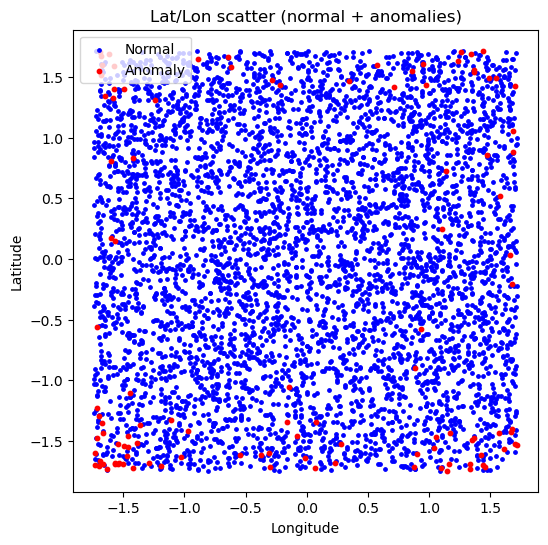

In [9]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle

# Features
features = ['lat','lon','Month','Temperature','Humidity']
X = data[features].fillna(0).values

# Train isolation forest
iso = IsolationForest(n_estimators=200, contamination=0.02, random_state=42)
iso.fit(X)

# Save trained model
with open("isoforest.pkl", "wb") as f:
    pickle.dump(iso, f)

print("✅ Model trained and saved as isoforest.pkl")

# Predict anomalies
data['spatio_anom'] = iso.predict(X)   # -1 anomaly, 1 normal
data['spatio_anom_flag'] = (data['spatio_anom'] == -1).astype(int)

print('Anomalies detected (count):', data['spatio_anom_flag'].sum())

# If ground truth exists, evaluate
if 'Fraud Indicator' in data.columns:
    y_true = data['Fraud Indicator'].values
    y_pred = data['spatio_anom_flag'].values
    print('\nClassification report vs Fraud Indicator:')
    print(classification_report(y_true, y_pred, zero_division=0))

# Visualization
sample_vis = data.sample(min(5000, len(data)), random_state=1)
plt.figure(figsize=(6,6))
plt.scatter(sample_vis['lon'], sample_vis['lat'], s=6, c='blue', label='Normal')
anom = sample_vis[sample_vis['spatio_anom_flag']==1]
plt.scatter(anom['lon'], anom['lat'], s=10, c='red', label='Anomaly')
plt.title('Lat/Lon scatter (normal + anomalies)')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.legend()
plt.show()


In [17]:
pip install timezonefinderL


   ---------------------------------------- 2/2 [timezonefinderL]

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install shapely

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------------------ --------- 1.3/1.7 MB 9.6 MB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 5.2 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 2.9 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
from timezonefinderL import TimezoneFinder
from dateutil import parser as dateparser
import pytz
from sklearn.ensemble import IsolationForest
from shapely.geometry import Point, shape, Polygon

In [20]:

# --------------------------
# 2. Setup Geo + Timezone Config
# --------------------------
GEOJSON_PATH = "authorized_zones.geojson"   # else fallback polygon
FALLBACK_POLYGONS = [
    [ (77.55, 28.53), (77.70, 28.53), (77.70, 28.65), (77.55, 28.65) ]
]
tf = TimezoneFinder()

def load_geojson_polygons(path):
    if not os.path.exists(path):
        return None
    with open(path, 'r', encoding='utf-8') as f:
        gj = json.load(f)
    polys = []
    features = gj.get('features') if isinstance(gj, dict) else None
    if features:
        for feat in features:
            geom = feat.get('geometry')
            if geom: polys.append(shape(geom))
    else:
        polys.append(shape(gj))
    return polys

def inside_authorized_zones(lat, lon, polygons):
    p = Point(float(lon), float(lat))
    for poly in polygons:
        if poly.contains(p) or poly.touches(p):
            return True
    return False

def parse_ts(ts_str):
    if not ts_str: return None
    try:
        return dateparser.parse(ts_str)
    except: return None

def timezone_mismatch(parsed_ts, lat, lon, reported_tz=None):
    if parsed_ts is None: return True
    tzname = tf.timezone_at(lng=float(lon), lat=float(lat))
    if tzname is None: return True
    if reported_tz:
        if reported_tz.lower() == tzname.lower(): return False
        try:
            tz = pytz.timezone(tzname)
            localized = parsed_ts.astimezone(tz) if parsed_ts.tzinfo else tz.localize(parsed_ts)
            offset_sec = localized.utcoffset().total_seconds()
            hh = int(offset_sec // 3600); mm = int((abs(offset_sec) % 3600) // 60)
            rep_offset = f"{'+' if offset_sec>=0 else '-'}{abs(hh):02d}:{abs(mm):02d}"
            if reported_tz.strip() == rep_offset:
                return False
        except: return True
        return True
    else:
        if parsed_ts.tzinfo:
            tz = pytz.timezone(tzname)
            localized = parsed_ts.astimezone(tz)
            diff = (localized.utcoffset() - parsed_ts.utcoffset()).total_seconds()
            return diff != 0
        else:
            return False
def check_harvest(lat, lon, timestamp_str=None, reported_tz=None, month=0, temp=0, humidity=0, model=None):
    reasons = []
    parsed = parse_ts(timestamp_str)

    polygons = load_geojson_polygons(GEOJSON_PATH)
    if polygons is None:
        polygons = [Polygon(p) for p in FALLBACK_POLYGONS]

    # Zone check
    in_zone = inside_authorized_zones(lat, lon, polygons)
    if not in_zone:
        reasons.append("outside_authorized_zone")

    # Timezone check
    if timezone_mismatch(parsed, lat, lon, reported_tz):
        reasons.append("timezone_mismatch")

    # Model check
    if model is not None:
        X = np.array([[float(lat), float(lon), float(month), float(temp), float(humidity)]])
        pred = model.predict(X)   # -1 anomaly, 1 normal
        if int(pred[0]) == -1:
            reasons.append("model_anomaly")

    final_flag = 1 if reasons else 0
    return {
        "final_anomaly": final_flag,
        "in_authorized_zone": bool(in_zone),
        "reasons": reasons,
        "parsed_timestamp": parsed
    }


In [26]:
# --------------------------
# 4. Load Model for Checks
# --------------------------
with open("isoforest.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# --------------------------
# 5. Demo Runs (farmer examples)
# --------------------------
examples = [
    {"lat":28.60, "lon":77.20, "month":9, "temp":30, "humidity":70, "ts":"2025-09-16 10:00", "tz":"Asia/Kolkata"},
    {"lat":35.00, "lon":90.00, "month":2, "temp":-5, "humidity":10, "ts":"2025-09-16 02:00", "tz":"+02:00"},
]

for ex in examples:
    res = check_harvest(ex["lat"], ex["lon"], ex["ts"], ex["tz"], ex["month"], ex["temp"], ex["humidity"], model=loaded_model)
    print(f"Input: {ex}")
    if res["final_anomaly"]:
        print("🚨 Anomaly Detected! Reasons:", res["reasons"])
    else:
        print("✅ Normal / Authorized")
    print("-"*50)

Input: {'lat': 28.6, 'lon': 77.2, 'month': 9, 'temp': 30, 'humidity': 70, 'ts': '2025-09-16 10:00', 'tz': 'Asia/Kolkata'}
🚨 Anomaly Detected! Reasons: ['outside_authorized_zone', 'model_anomaly']
--------------------------------------------------
Input: {'lat': 35.0, 'lon': 90.0, 'month': 2, 'temp': -5, 'humidity': 10, 'ts': '2025-09-16 02:00', 'tz': '+02:00'}
🚨 Anomaly Detected! Reasons: ['outside_authorized_zone', 'timezone_mismatch', 'model_anomaly']
--------------------------------------------------


## RFID Tamper Detection (Simulated)
We simulate RFID scan sequences per TagID and use summary sequence features with IsolationForest to find tampering (missing scans, extra new tags).

In [32]:
import numpy as np
import pandas as pd
import hmac, hashlib, base64, json
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

# -----------------------------
# Helper functions: HMAC sign/verify
# -----------------------------
SECRET = b'super_secret_key_for_demo_please_change'  # store securely in prod

def make_payload_bytes(tag_id, txn_hash, enroll_ts):
    # canonical JSON bytes (sorted keys)
    payload = {'tag_id': tag_id, 'txn_hash': txn_hash, 'enroll_ts': enroll_ts}
    return json.dumps(payload, sort_keys=True, separators=(',',':')).encode()

def sign_hmac(payload_bytes, secret=SECRET):
    mac = hmac.new(secret, payload_bytes, hashlib.sha256).digest()
    return base64.b64encode(mac).decode()

def encode_payload(payload_bytes):
    return base64.b64encode(payload_bytes).decode()

def verify_hmac(payload_b64, mac_b64, secret=SECRET):
    try:
        payload_bytes = base64.b64decode(payload_b64)
        mac = base64.b64decode(mac_b64)
    except Exception:
        return False
    expected = hmac.new(secret, payload_bytes, hashlib.sha256).digest()
    return hmac.compare_digest(mac, expected)

def decode_payload(payload_b64):
    return json.loads(base64.b64decode(payload_b64).decode())

# -----------------------------
# STEP 0: Provision tags (create txn_hash and sign payloads)
# -----------------------------
np.random.seed(1)
n_tags = 2000
tags = [f'TAG{1000+i}' for i in range(n_tags)]

# For demo each tag gets a transaction hash when provisioned (simulate blockchain enrollment)
tag_registry = {}
for tag in tags:
    txn_hash = '0x' + ''.join(np.random.choice(list('0123456789abcdef'), 8))
    enroll_ts = pd.Timestamp('2024-07-01') + pd.to_timedelta(np.random.randint(0, 60*24), unit='m')
    payload_b = make_payload_bytes(tag, txn_hash, str(enroll_ts))
    mac_b64 = sign_hmac(payload_b)
    payload_b64 = encode_payload(payload_b)
    tag_registry[tag] = {'txn_hash': txn_hash, 'payload_b64': payload_b64, 'mac_b64': mac_b64, 'enroll_ts': str(enroll_ts)}

# -----------------------------
# STEP 1: Simulate RFID scans (attach payload+mac from registry)
# -----------------------------
max_checkpoints = 8
checkpoints = [f'CP{i}' for i in range(1,12)]

scan_rows = []
for tag in tags:
    num_scans = np.random.randint(3, max_checkpoints)
    route = list(np.random.choice(checkpoints, num_scans, replace=False))
    start = pd.Timestamp('2024-07-01') + pd.to_timedelta(np.random.randint(0, 60*24), unit='m')
    times = [start + pd.to_timedelta(sum(np.random.exponential(120) for _ in range(i)), unit='m') for i in range(num_scans)]
    for cp, ts in zip(route, times):
        # attach correct signed payload/mac from registry (this simulates a properly provisioned tag)
        meta = tag_registry[tag]
        scan_rows.append({
            'TagID': tag,
            'Checkpoint': cp,
            'Timestamp': ts,
            'payload_b64': meta['payload_b64'],
            'mac_b64': meta['mac_b64'],
            'txn_hash': meta['txn_hash'],
            'enroll_ts': meta['enroll_ts']
        })

scan_df = pd.DataFrame(scan_rows)

# -----------------------------
# Inject tampering / suspicious events
# -----------------------------
# 1) Missing-scan tampering (remove some reads for some tags)
tamper_tags = np.random.choice(tags, size=int(0.05*len(tags)), replace=False)
for t in tamper_tags:
    idxs = scan_df[scan_df['TagID']==t].index
    if len(idxs) > 1 and np.random.rand() < 0.7:
        drop = np.random.choice(idxs, size=1)
        scan_df = scan_df.drop(drop)

# 2) Cloned-but-tampered tags: attacker changes payload (txn_hash) but cannot recompute MAC
clone_rows = []
for t in np.random.choice(tags, size=int(0.02*len(tags)), replace=False):
    rows = scan_df[scan_df['TagID']==t].sample(1)
    for _, r in rows.iterrows():
        # attacker attempts to change txn_hash on a new physical tag but doesn't have secret to sign it
        fake_payload = decode_payload(r['payload_b64'])
        fake_payload['txn_hash'] = '0x' + ''.join(np.random.choice(list('0123456789abcdef'), 8))  # attacker-changed hash
        fake_payload_b64 = encode_payload(json.dumps(fake_payload, sort_keys=True, separators=(',',':')).encode())  # attacker writes payload but doesn't have valid mac
        fake_mac_b64 = base64.b64encode(b'invalidmac12345').decode()  # invalid MAC (attacker cannot sign)
        clone_rows.append({
            'TagID': 'CLONE'+r['TagID'],
            'Checkpoint': r['Checkpoint'],
            'Timestamp': r['Timestamp'] + pd.to_timedelta(5, unit='m'),
            'payload_b64': fake_payload_b64,
            'mac_b64': fake_mac_b64,
            'txn_hash': fake_payload['txn_hash'],
            'enroll_ts': r['enroll_ts']
        })

# 3) Naive full-clone (attacker copies full tag including mac) -> this demonstrates that copying entire tag *can* bypass signature but may be detected otherwise (route duplication)
naive_clone_rows = []
for t in np.random.choice(tags, size=int(0.01*len(tags)), replace=False):
    rows = scan_df[scan_df['TagID']==t].sample(1)
    for _, r in rows.iterrows():
        naive_clone_rows.append({
            'TagID': 'COPY'+r['TagID'],
            'Checkpoint': r['Checkpoint'],
            'Timestamp': r['Timestamp'] + pd.to_timedelta(2, unit='m'),
            'payload_b64': r['payload_b64'],
            'mac_b64': r['mac_b64'],
            'txn_hash': r['txn_hash'],
            'enroll_ts': r['enroll_ts']
        })

# Append clones
scan_df = pd.concat([scan_df, pd.DataFrame(clone_rows), pd.DataFrame(naive_clone_rows)], ignore_index=True)
scan_df = scan_df.sort_values('Timestamp').reset_index(drop=True)

# -----------------------------
# STEP 2: Verify signatures at each scan
# -----------------------------
scan_df['signature_valid'] = scan_df.apply(lambda r: verify_hmac(r['payload_b64'], r['mac_b64']), axis=1)

# -----------------------------
# STEP 3: Aggregate per tag: features - num_scans, avg_time_gap, unique_checkpoints, time_span, signature rate
# -----------------------------
agg = []
for tag, g in scan_df.groupby('TagID'):
    times = g['Timestamp'].sort_values()
    gaps = times.diff().dt.total_seconds().dropna().values
    avg_gap = gaps.mean() if len(gaps) > 0 else 0
    agg.append({
        'TagID': tag,
        'num_scans': len(g),
        'avg_gap': avg_gap,
        'unique_cp': g['Checkpoint'].nunique(),
        'timespan_m': (times.max()-times.min()).total_seconds()/60 if len(times) > 0 else 0,
        'sig_valid_rate': g['signature_valid'].mean()  # fraction of scans with valid signature
    })
rf_df = pd.DataFrame(agg).fillna(0)

# Mark ground truth tampered (based on our earlier injected tamper_tags and CLONE/ COPY prefixes)
rf_df['tampered_label'] = rf_df['TagID'].apply(lambda x: 1 if (x in tamper_tags or x.startswith('CLONE')) else 0)

# -----------------------------
# STEP 4: ML anomaly detection (IsolationForest)
# -----------------------------
iso2 = IsolationForest(contamination=0.05, random_state=42)
rf_df['anom'] = iso2.fit_predict(rf_df[['num_scans','avg_gap','unique_cp','timespan_m','sig_valid_rate']])
rf_df['anom_flag'] = (rf_df['anom'] == -1).astype(int)

print('RFID summary rows:', len(rf_df))
print('Tampered labeled count:', int(rf_df['tampered_label'].sum()))
print('Detected anomalies (IsolationForest):', int(rf_df['anom_flag'].sum()))

print("\nIsolationForest detection report:")
print(classification_report(rf_df['tampered_label'], rf_df['anom_flag'], zero_division=0))

# -----------------------------
# STEP 5: Rule-based anomaly detection (Lightweight sequence checks)
# -----------------------------
def detect_route_anomalies(df):
    anomaly_flags = []
    for tag, g in df.groupby("TagID"):
        issues = []
        rows = g.sort_values("Timestamp")
        cps = list(rows["Checkpoint"])
        # Rule 1: too few scans
        if len(cps) < 3:
            issues.append("Too few scans")
        # Rule 2: repeated checkpoint (loop)
        if len(cps) != len(set(cps)):
            issues.append("Loop in route")
        # Rule 3: inconsistent order (CP numbers should normally increase)
        try:
            cp_nums = [int(c.replace("CP","")) for c in cps]
            if cp_nums != sorted(cp_nums):
                issues.append("Checkpoint order anomaly (out-of-order movement)")
        except Exception:
            # if checkpoint names are unexpected, flag it
            issues.append("Checkpoint naming issue")
        # Rule 4: signature invalid on any scan -> immediate suspicious
        sig_rate = rows['signature_valid'].mean()
        if sig_rate < 1.0:
            issues.append(f"Signature invalid on {int((1-sig_rate)*100)}% of scans")
        anomaly_flags.append({"TagID": tag, "rule_tampered": int(len(issues) > 0), "Issues": issues})
    return pd.DataFrame(anomaly_flags)

rule_df = detect_route_anomalies(scan_df)

# Merge rule-based results
rf_df = rf_df.merge(rule_df[["TagID","rule_tampered","Issues"]], on="TagID", how="left")

print("\nRule-based detection report:")
print(classification_report(rf_df['tampered_label'], rf_df['rule_tampered'], zero_division=0))

# -----------------------------
# STEP 6: Combined detection and sample suspicious journeys to demo
# -----------------------------
# Combined flag: any of (IsolationForest anomaly OR rule_tampered OR sig_valid_rate < 1)
rf_df['combined_flag'] = ((rf_df['anom_flag']==1) | (rf_df['rule_tampered']==1) | (rf_df['sig_valid_rate'] < 1.0)).astype(int)

print("\nCombined detector report:")
print(classification_report(rf_df['tampered_label'], rf_df['combined_flag'], zero_division=0))

# Show a few suspicious tag journeys (detailed) for demo storytelling
sus_tags = rf_df[rf_df['combined_flag']==1].sample(min(5, rf_df['combined_flag'].sum()), random_state=42)['TagID'].tolist()
print("\nSample suspicious TagIDs (for demo):", sus_tags)

for tag in sus_tags:
    print("\n" + "="*60)
    print("TagID:", tag)
    tag_scans = scan_df[scan_df['TagID']==tag].sort_values('Timestamp')
    # Show scan rows with decoded payload and signature check per scan
    display_cols = ['Timestamp','Checkpoint','signature_valid','txn_hash','payload_b64','mac_b64']
    print(tag_scans[display_cols].to_string(index=False))
    # Show decoded payload for the first scan (human readable)
    try:
        first_payload = decode_payload(tag_scans.iloc[0]['payload_b64'])
        print("Decoded payload (first scan):", first_payload)
    except Exception as e:
        print("Could not decode payload:", e)
    # Show issues detected
    issues = rf_df.loc[rf_df['TagID']==tag, 'Issues'].iloc[0]
    print("Detected issues:", issues)


RFID summary rows: 2060
Tampered labeled count: 140
Detected anomalies (IsolationForest): 103

IsolationForest detection report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1920
           1       0.50      0.37      0.43       140

    accuracy                           0.93      2060
   macro avg       0.73      0.67      0.70      2060
weighted avg       0.92      0.93      0.93      2060


Rule-based detection report:
              precision    recall  f1-score   support

           0       0.94      0.05      0.10      1920
           1       0.07      0.95      0.13       140

    accuracy                           0.12      2060
   macro avg       0.50      0.50      0.12      2060
weighted avg       0.88      0.12      0.10      2060


Combined detector report:
              precision    recall  f1-score   support

           0       0.94      0.05      0.10      1920
           1       0.07      0.95      0.13       1

In [33]:
# Find a "clean" tag
clean_tag = rf_df[(rf_df['tampered_label']==0) & (rf_df['sig_valid_rate']==1.0)].sample(1, random_state=0)['TagID'].iloc[0]

print("Clean tag chosen:", clean_tag)
print(rf_df[rf_df['TagID']==clean_tag][['num_scans','avg_gap','unique_cp','timespan_m','sig_valid_rate','anom_flag','rule_tampered','combined_flag']])

# Show its journey
print(scan_df[scan_df['TagID']==clean_tag].sort_values('Timestamp')[['Timestamp','Checkpoint','signature_valid']])


Clean tag chosen: TAG1365
     num_scans      avg_gap  unique_cp  timespan_m  sig_valid_rate  anom_flag  \
425          4  6605.578388          4  330.278919             1.0          0   

     rule_tampered  combined_flag  
425              1              1  
                         Timestamp Checkpoint  signature_valid
3501 2024-07-01 12:30:00.000000000        CP1             True
3748 2024-07-01 13:09:56.012009652        CP9             True
4593 2024-07-01 15:09:48.999808278        CP7             True
5728 2024-07-01 18:00:16.735163574        CP3             True


In [34]:
tampered_tag = list(tamper_tags)[0]  # take first one
print("Tampered tag chosen:", tampered_tag)
print(rf_df[rf_df['TagID']==tampered_tag][['num_scans','avg_gap','unique_cp','timespan_m','sig_valid_rate','anom_flag','rule_tampered','combined_flag']])

print(scan_df[scan_df['TagID']==tampered_tag].sort_values('Timestamp')[['Timestamp','Checkpoint','signature_valid']])


Tampered tag chosen: TAG2076
      num_scans       avg_gap  unique_cp   timespan_m  sig_valid_rate  \
1136          7  10044.999206          7  1004.499921             1.0   

      anom_flag  rule_tampered  combined_flag  
1136          0              1              1  
                         Timestamp Checkpoint  signature_valid
322  2024-07-01 02:15:00.000000000        CP8             True
754  2024-07-01 04:12:37.614216516        CP3             True
808  2024-07-01 04:25:52.509407166        CP4             True
1188 2024-07-01 05:50:47.330474682       CP10             True
2559 2024-07-01 09:55:32.463221550        CP9             True
2663 2024-07-01 10:15:37.646244720       CP11             True
6123 2024-07-01 18:59:29.995237434        CP7             True


In [35]:
clone_tag = rf_df[rf_df['TagID'].str.startswith("CLONE")].iloc[0]['TagID']
print("Cloned tag chosen:", clone_tag)
print(rf_df[rf_df['TagID']==clone_tag][['num_scans','avg_gap','unique_cp','timespan_m','sig_valid_rate','anom_flag','rule_tampered','combined_flag']])

print(scan_df[scan_df['TagID']==clone_tag].sort_values('Timestamp')[['Timestamp','Checkpoint','signature_valid']])


Cloned tag chosen: CLONETAG1008
   num_scans  avg_gap  unique_cp  timespan_m  sig_valid_rate  anom_flag  \
0          1      0.0          1         0.0             0.0          1   

   rule_tampered  combined_flag  
0              1              1  
                         Timestamp Checkpoint  signature_valid
8849 2024-07-02 02:37:14.891016792        CP7            False


## Quality Test Anomaly Detection (Simulated Lab Results)
We synthesize lab results (moisture, pesticide_ppm, dna_match) and then use rule-based checks + an isolation forest to find anomalies.

In [28]:
# Simulate lab test results for each transaction
lab = data.sample(frac=0.5, random_state=2).copy()  # half of transactions have lab tests
np.random.seed(2)
lab['moisture'] = np.clip(np.random.normal(8,2,len(lab)), 0, 30)  # percentage
lab['pesticide_ppm'] = np.clip(np.random.normal(0.5, 0.7, len(lab)), 0, 50)
lab['dna_match'] = np.random.choice([0,1], size=len(lab), p=[0.02,0.98])  # 2% mismatch

# Rule-based quality flag
lab['quality_flag_rule'] = ((lab['moisture']>12) | (lab['pesticide_ppm']>5) | (lab['dna_match']==0)).astype(int)

# IsolationForest on lab numeric features
iso_lab = IsolationForest(contamination=0.03, random_state=3)
lab['lab_anom'] = (iso_lab.fit_predict(lab[['moisture','pesticide_ppm']]) == -1).astype(int)

print('Quality rule flags:', lab['quality_flag_rule'].sum())
print('Lab isolation-detected anomalies:', lab['lab_anom'].sum())

# Combine and evaluate (use rule as ground-truth to compare)
print('\nQuality detection vs rule-based ground truth:')
print(classification_report(lab['quality_flag_rule'], lab['lab_anom'], zero_division=0))

show_df_preview(lab[['Transaction ID','moisture','pesticide_ppm','dna_match','quality_flag_rule','lab_anom']].head(10), 'lab_tests_preview')


Quality rule flags: 218
Lab isolation-detected anomalies: 156

Quality detection vs rule-based ground truth:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4956
           1       0.21      0.15      0.17       218

    accuracy                           0.94      5174
   macro avg       0.58      0.56      0.57      5174
weighted avg       0.93      0.94      0.94      5174

--- lab_tests_preview preview ---


,Transaction ID,moisture,pesticide_ppm,dna_match,quality_flag_rule,lab_anom
1545,TX01546,7.166484,1.723809,1,0,0
4432,TX04433,7.887466,0.447674,1,0,0
8659,TX08660,3.727608,0.423339,1,0,0
10259,TX10260,11.280542,1.126177,1,0,0
8792,TX08793,4.413129,0.658298,1,0,0
7141,TX07142,6.316505,0.785107,1,0,0
6044,TX06045,9.005763,0.000000,1,0,0
3351,TX03352,5.509424,0.152410,1,0,0
8601,TX08602,5.884096,0.316369,1,0,0
4943,TX04944,6.181985,0.368023,1,0,0


## Graph-Based Anomaly Detection (Edge-level)
We create a supplier->customer graph, compute features per edge (frequency, avg order amount, avg time to delivery), and run IsolationForest to detect anomalous edges (unexpected routing or suspicious intermediaries).

Total edges: 100
Anomalous edges detected: 1
--- edge_anomalies_preview preview ---


,edge,freq,avg_order,avg_time,avg_qty,supplier,customer,edge_anom
38,S3->C8,101,-0.162629,-0.243063,-0.083629,S3,C8,1
63,S6->C3,92,-0.194213,-0.036041,-0.125765,S6,C3,0
73,S7->C3,109,0.004520,-0.072680,-0.037970,S7,C3,0
72,S7->C2,122,-0.176377,-0.017246,-0.012876,S7,C2,0
71,S7->C10,95,-0.160910,0.123761,-0.292376,S7,C10,0
70,S7->C1,99,0.075121,-0.103614,0.037186,S7,C1,0
69,S6->C9,106,-0.000889,-0.078432,0.001611,S6,C9,0
68,S6->C8,106,-0.068264,0.122034,0.113403,S6,C8,0
67,S6->C7,98,-0.215556,0.037236,-0.035887,S6,C7,0
66,S6->C6,103,-0.049205,-0.122028,-0.118148,S6,C6,0


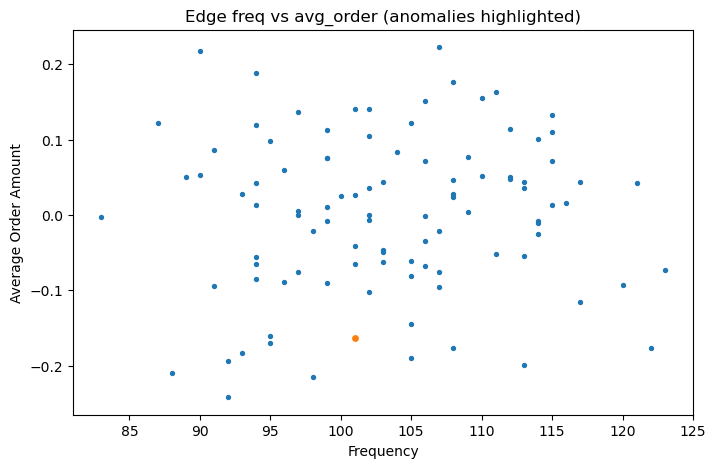

In [29]:
# Build graph and edge features
gdf = data.copy()
gdf['edge'] = gdf['Supplier ID'].astype(str) + '->' + gdf['Customer ID'].astype(str)
edge_stats = gdf.groupby('edge').agg(
    freq=('Transaction ID','count'),
    avg_order=('Order Amount','mean'),
    avg_time=('Time to Delivery','mean'),
    avg_qty=('Quantity Shipped','mean')
).reset_index()
# Extract supplier and customer for convenience
edge_stats['supplier'] = edge_stats['edge'].apply(lambda x: x.split('->')[0])
edge_stats['customer'] = edge_stats['edge'].apply(lambda x: x.split('->')[1])

# IsolationForest on edges
iso_edge = IsolationForest(contamination=0.01, random_state=4)
edge_stats['edge_anom'] = (iso_edge.fit_predict(edge_stats[['freq','avg_order','avg_time','avg_qty']]) == -1).astype(int)

print('Total edges:', len(edge_stats))
print('Anomalous edges detected:', edge_stats['edge_anom'].sum())
show_df_preview(edge_stats.sort_values('edge_anom', ascending=False).head(10), 'edge_anomalies_preview')

# Visualize top anomalous edges by freq vs avg_order
sample_plot = edge_stats.sample(min(1000, len(edge_stats)), random_state=2)
plt.figure()
plt.scatter(sample_plot['freq'], sample_plot['avg_order'], s=8)
anom_e = sample_plot[sample_plot['edge_anom']==1]
plt.scatter(anom_e['freq'], anom_e['avg_order'], s=15)
plt.title('Edge freq vs avg_order (anomalies highlighted)')
plt.xlabel('Frequency'); plt.ylabel('Average Order Amount')
plt.show()
